## Porto Seguro’s Safe Driver Prediction

<br><font color=blue>The aim of this compitation is to predict probability that a driver will intiate an auto insurance claim next year.A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers. </font>


**Steps**

1. [Read data set](#Read-data-set)
2. [Explore data set](#Explore-data-set)
3. [Correlation plot](#Correlation-plot)
4. [Missing value is data set](#Missing-value-is-data-set)
5. [Convert variables into category type](#Convert-variables-into-category-type)
6. [Univariate analysis](#Univariate-analysis)
7. [Descrictive Statistic Features](#Descrictive-Statistic-Features)
8. [Determine outliers in dataset](#Determine-outliers-in-dataset)
9. [One Hot Encoding](#One-Hot-Encoding)
10. [Split data set](#Split-data-set)
11. [Hyperparameter tuning](#Hyperparameter-tuning)
12. [Logistic Regression model](#Logistic-Regression-model)
13. [Model performance](#Model-performance)
14. [Reciever Operating Charactaristics](#Reciever-Operating-Charactaristics)
15. [Predict for unseen data set](#Predict-for-unseen-data-set)

In [54]:
!pip install seaborn
!pip install lightgbm
!pip install missingno

## Import library

In [55]:
#Import library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.model_selection import StratifiedKFold,GridSearchCV
import missingno as mssno
seed =45
%matplotlib inline

In [56]:
MODELS = {
    "LGBM":lgbm.LGBMClassifier(n_estimators=600, objective='binary' ),
     "LOGI":LogisticRegression()
}

In [57]:
MODEL=MODELS["LGBM"]
IS_OHE=True
IS_DROP_COEFF_ZERO=True
IS_ADD_NULL_VAL_INFO=True

## Read data set

In [58]:
path = '../input/'
#path = 'dataset/'
train = pd.read_csv(path+'train.csv',na_values=-1)
test = pd.read_csv(path+'test.csv',na_values=-1)
print('Number rows and columns:',train.shape)
print('Number rows and columns:',test.shape)

Number rows and columns: (595212, 59)
Number rows and columns: (892816, 58)


Porto Seguro provided close to 600k and 900k observation of train and test dataset respectively. They were 57 feature anonymized in order to protect company trade secrets, but they were given bit informaation about  The train and test data set contains feature with similar grouping are tagged with (e.g., ind, reg, car, cat, calc, bin). Values of  -1 indicate that the feature was missing from the observation.

Porto Seguroはそれぞれ列車と試験データセットの600 kと900 kに近い観測を提供した。これらは、企業の企業秘密を保護するために匿名化された57の特徴であったが、列車とテストのデータセットには、同様のグループ化が(例:ind, reg, car, cat, calc, bin)のタグが付けられた特徴が含まれていることに関するビット情報が与えられた。-1の値は、その特徴が観測から欠落していたことを示します。

## Explore data set

In [59]:
train.head(3).T

,0,1,2
id,7.000000,9.000000,13.000000
target,0.000000,0.000000,0.000000
ps_ind_01,2.000000,1.000000,5.000000
ps_ind_02_cat,2.000000,1.000000,4.000000
ps_ind_03,5.000000,7.000000,9.000000
ps_ind_04_cat,1.000000,0.000000,1.000000
ps_ind_05_cat,0.000000,0.000000,0.000000
ps_ind_06_bin,0.000000,0.000000,0.000000
ps_ind_07_bin,1.000000,0.000000,0.000000
ps_ind_08_bin,0.000000,1.000000,1.000000


## Target varaiable

0    573518
1     21694
Name: target, dtype: int64

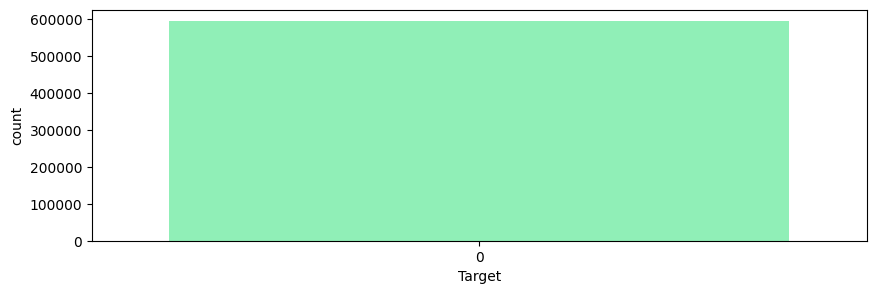

In [60]:
plt.figure(figsize=(10,3))
sns.countplot(train['target'],palette='rainbow')
plt.xlabel('Target')

train['target'].value_counts()

The 'target' variable in imbalanced. The target column in data set is whether or not claim was filed for that policy holder. The target variable is quite unbalanced, with only  %4 of  policyholders in training data filing claim within the year.

'target'変数が不均衡です。データセットのターゲット列は、そのポリシー保持者に対してクレームが提出されたかどうかです。目標変数は非常に不均衡であり、トレーニングデータファイリングの契約者のうち年内に請求するのは%4人のみである。

## Correlation plot
Correlation is a measure bivariate analysis that measure the strength of assciation between variable and direction of relationship.In terms of strength of relationship, the value of the correlation coefficient varies between +1 and -1

相関は、変数と関係の方向の間の関連の強さを測定する測度二変量解析である。相関係数の値は、相関の強さでは+1から-1の間で変化する

<AxesSubplot: >

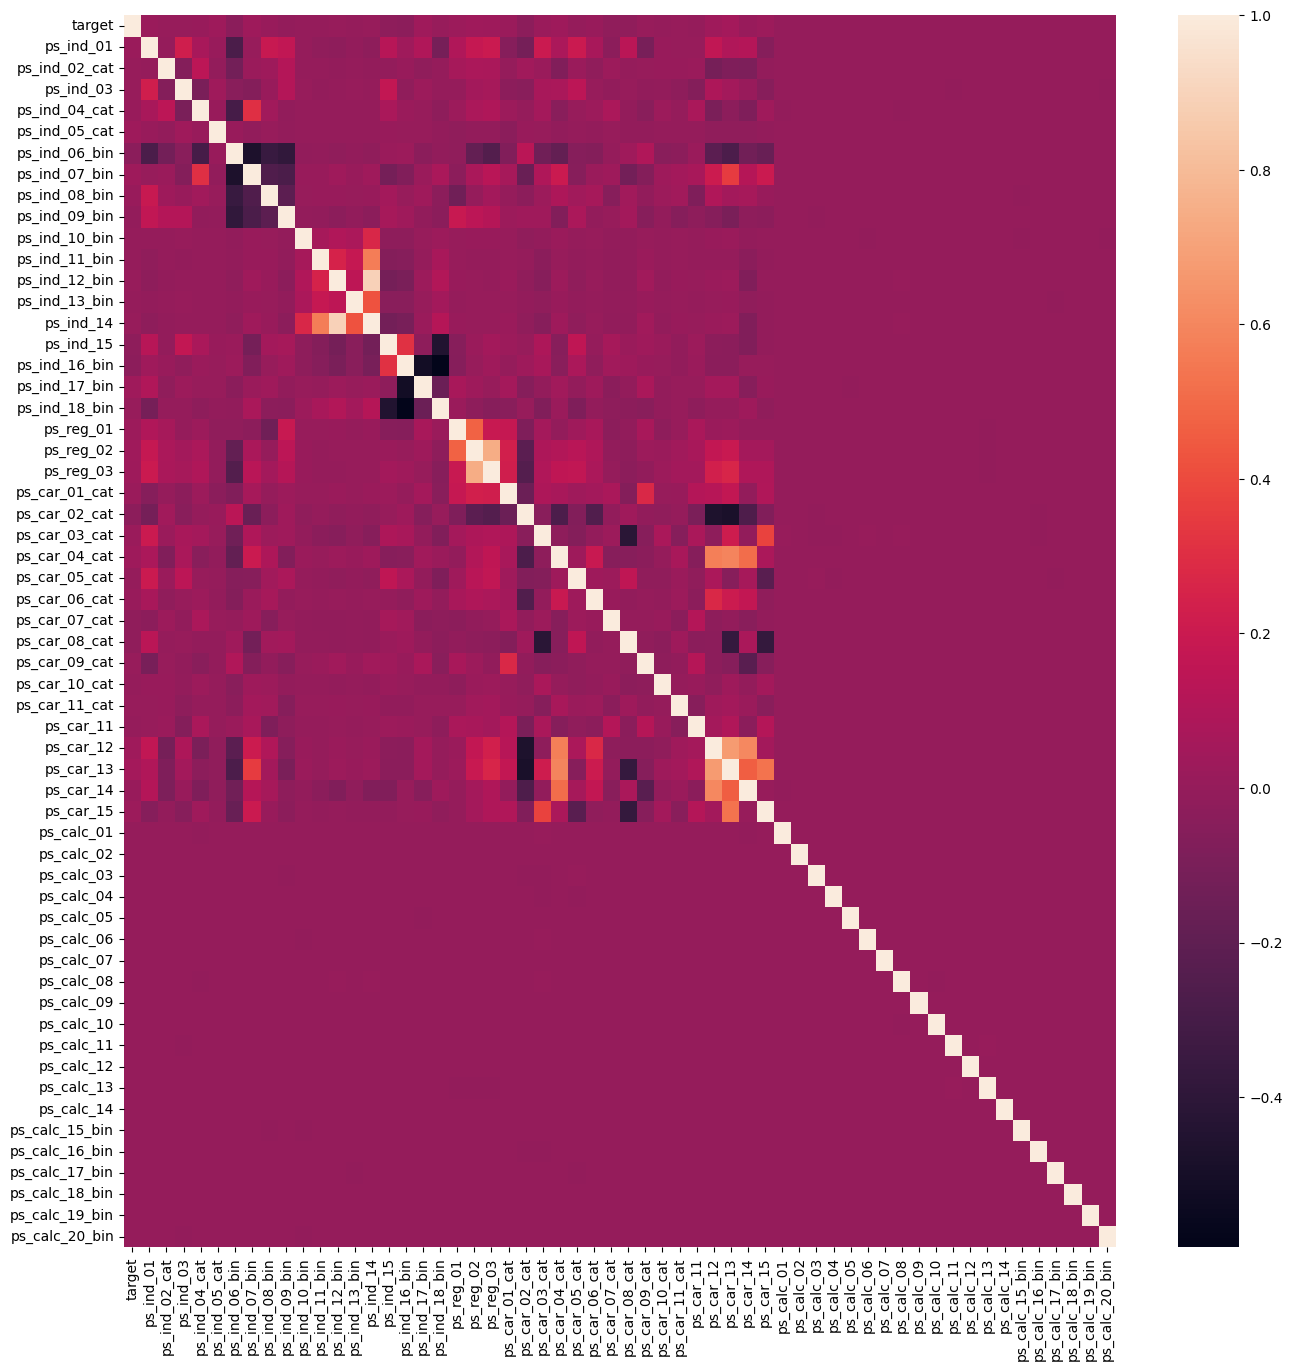

In [61]:
cor = train.drop('id',axis=1).corr()
plt.figure(figsize=(16,16))
sns.heatmap(cor)

> The correlation coefficient for **ps_calc** is 0,so we will drop these from our dataset.

> **ps_calc**の相関係数は0であるため、データセットからこれらを削除します。

In [62]:
ps_cal = train.columns[train.columns.str.startswith('ps_calc')]
if IS_DROP_COEFF_ZERO:
    train = train.drop(ps_cal,axis =1)
    test = test.drop(ps_cal,axis=1)
train.shape

(595212, 39)

## Missing value is data set
>Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.
>-1の値は、その特徴が観測から欠落していたことを示します。ターゲット列は、そのポリシー保持者に対してクレームが提出されたかどうかを示します。

<AxesSubplot: >

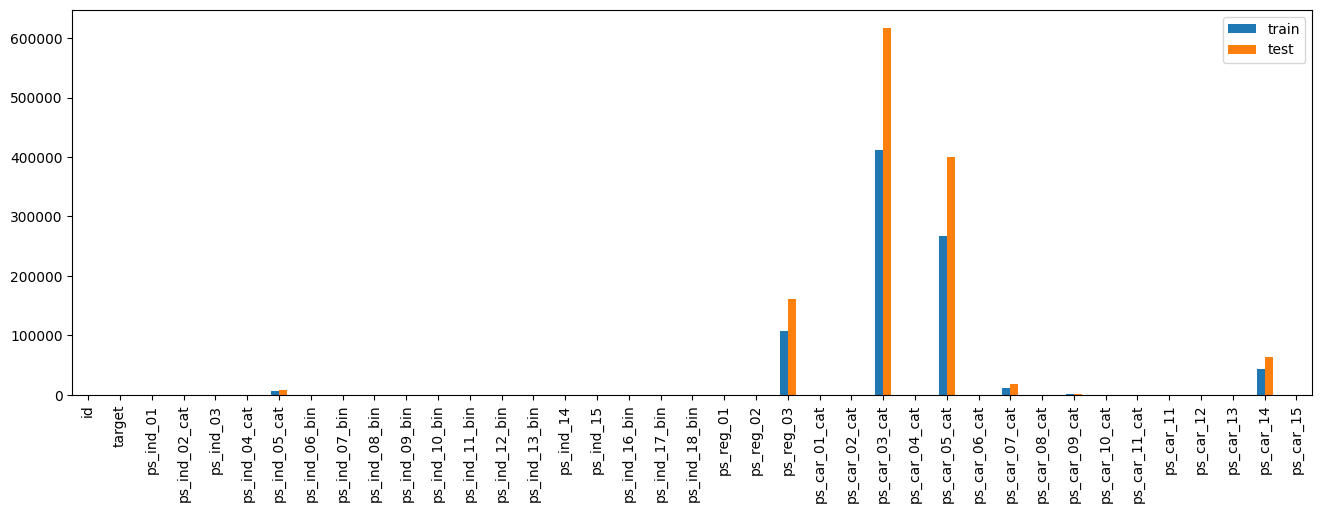

In [63]:
k= pd.DataFrame()
k['train']= train.isnull().sum()
k['test'] = test.isnull().sum()
fig,ax = plt.subplots(figsize=(16,5))
k.plot(kind='bar',ax=ax)

## 欠損値が１以上あるという情報を加える

In [64]:
def add_null_val_flag(df=None,cols_with_missing=None):
    # 欠損値を含む列を選択
    if cols_with_missing is None:
        cols_with_missing = df.columns[df.isnull().any()].tolist()
    print(cols_with_missing)

    # 欠損値があることを示すフラグ列を作成
    for col in cols_with_missing:
        df[col + '_missing'] = df[col].isnull().astype(int)

    return df,cols_with_missing

In [65]:
if IS_ADD_NULL_VAL_INFO:
    train,train_cols_with_missing =add_null_val_flag(train,None)
    test,_=add_null_val_flag(test,train_cols_with_missing)

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_12', 'ps_car_14']
['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_12', 'ps_car_14']


In [66]:
train.head(2)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_reg_03_missing,ps_car_01_cat_missing,ps_car_02_cat_missing,ps_car_03_cat_missing,ps_car_05_cat_missing,ps_car_07_cat_missing,ps_car_09_cat_missing,ps_car_11_missing,ps_car_12_missing,ps_car_14_missing
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,0,0,0,1,1,0,0,0,0,0


Missing value in test train data set are in same propotion and same column

テスト列車のデータセットの欠損値は、同じ比率と同じ列にある

<AxesSubplot: >

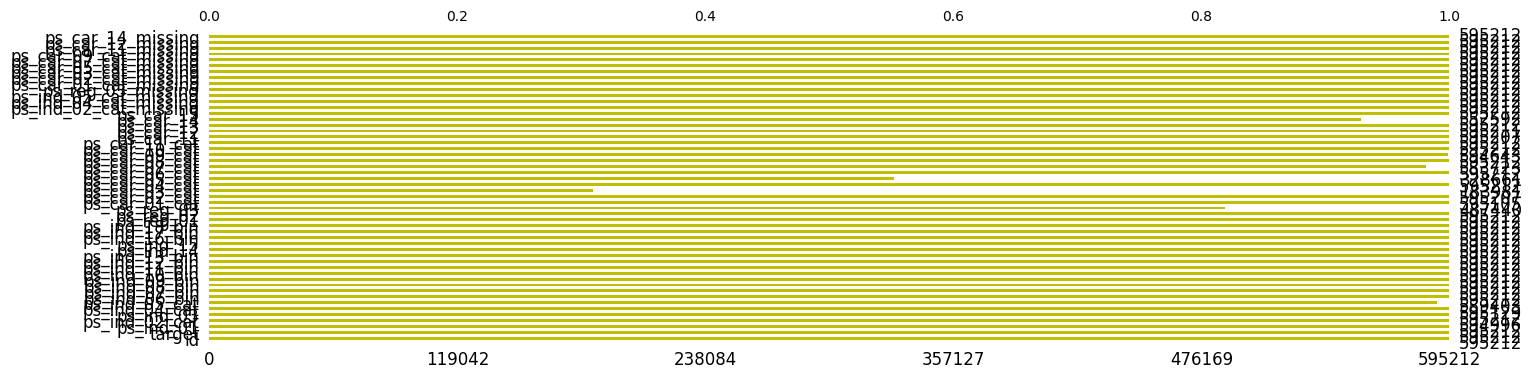

In [67]:
mssno.bar(train,color='y',figsize=(16,4),fontsize=12)

<AxesSubplot: >

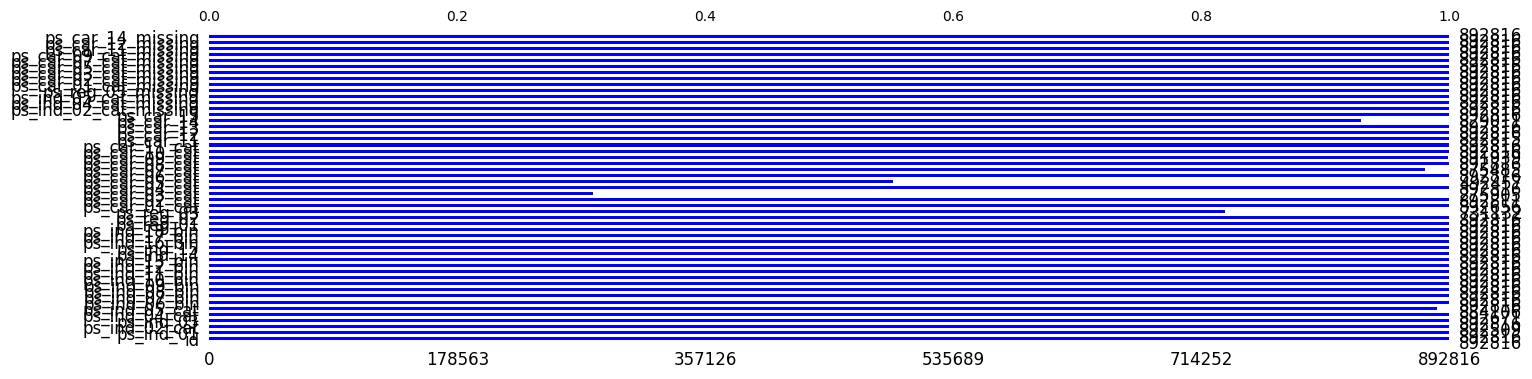

In [68]:
mssno.bar(test,color='b',figsize=(16,4),fontsize=12)

<AxesSubplot: >

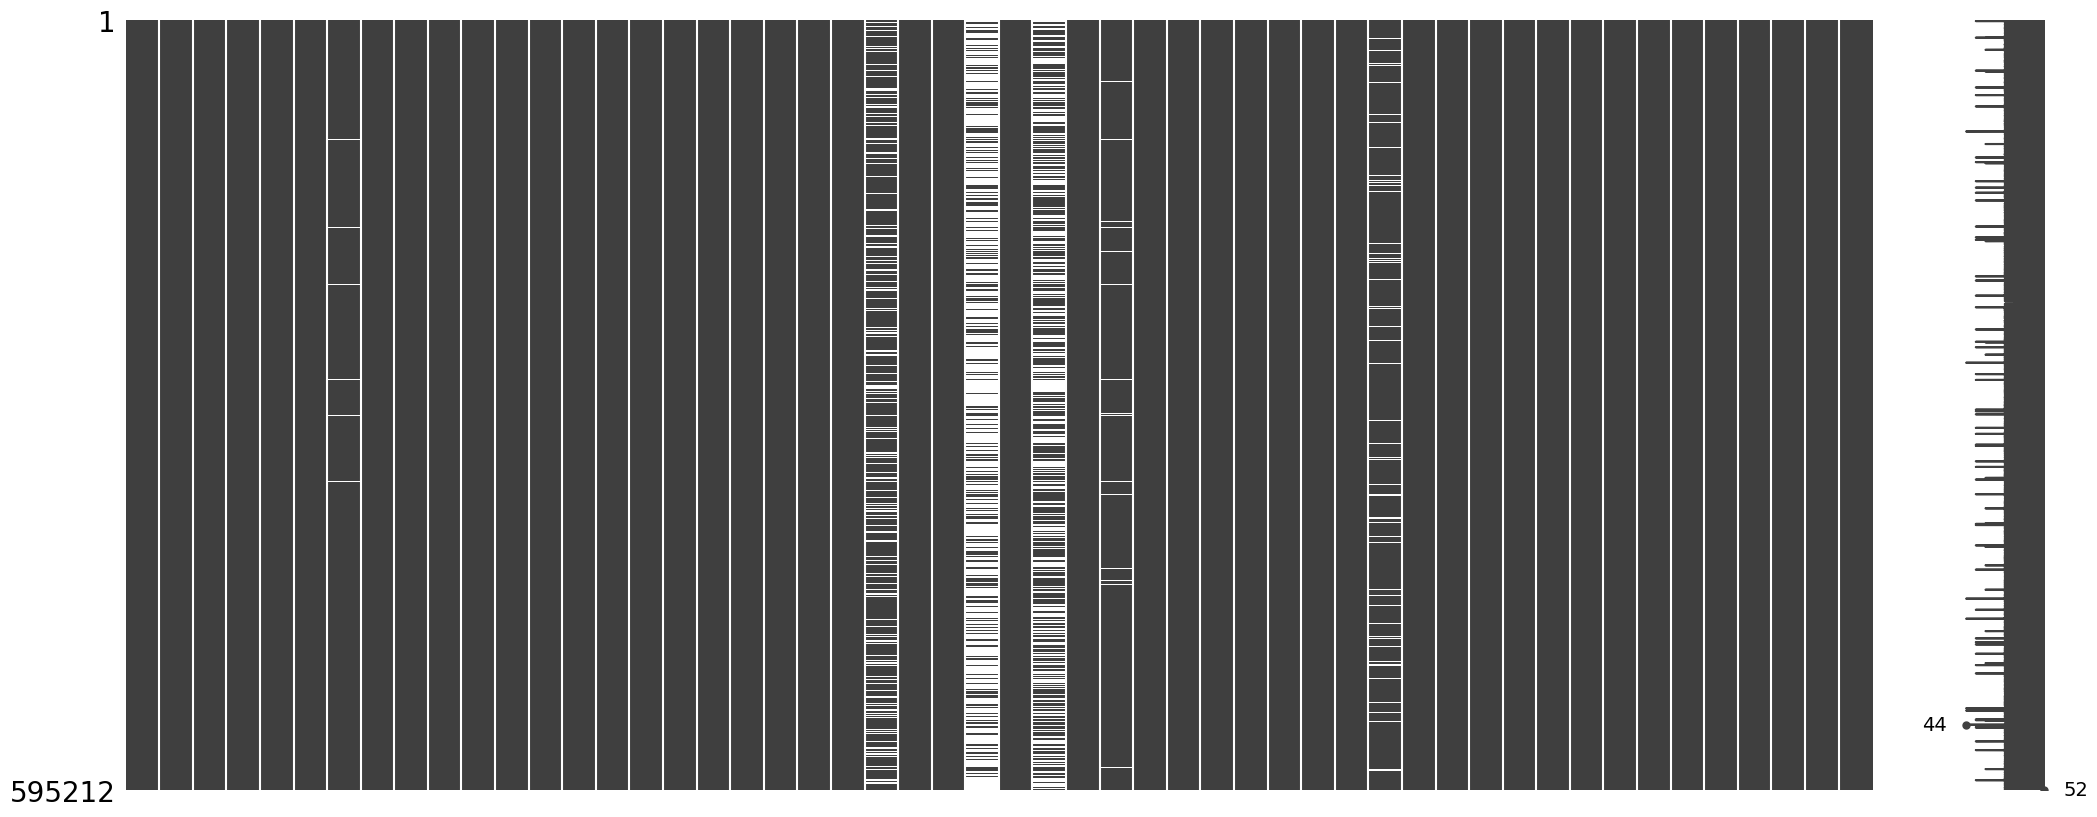

In [69]:
mssno.matrix(train)

### Replace missing value with mode

In [70]:
def missing_value(df):
    col = df.columns
    # 最頻値による欠損地補完
    for i in col:
        if df[i].isnull().sum()>0:
            df[i].fillna(df[i].mode()[0],inplace=True)

In [71]:
missing_value(train)
missing_value(test)

## Convert variables into category type

In [72]:
def basic_details(df):
    b = pd.DataFrame()
    b['Missing value'] = df.isnull().sum()
    b['N unique value'] = df.nunique()
    b['dtype'] = df.dtypes
    return b
basic_details(train)

,Missing value,N unique value,dtype
id,0,595212,int64
target,0,2,int64
ps_ind_01,0,8,int64
ps_ind_02_cat,0,4,float64
ps_ind_03,0,12,int64
ps_ind_04_cat,0,2,float64
ps_ind_05_cat,0,7,float64
ps_ind_06_bin,0,2,int64
ps_ind_07_bin,0,2,int64
ps_ind_08_bin,0,2,int64


>The unique value of "ps_car_11_cat" is maximum in the data set is 104

## カテゴリ変数に変換

In [73]:
def category_type(df):
    col = df.columns
    for i in col:
        if df[i].nunique()<=104:
            #print(df[i].nunique())
            # print(df[i].astype("category"))
            df[i] = df[i].astype('category')
category_type(train)
category_type(test)

## Descrictive Statistic Features

In [74]:
def descrictive_stat_feat(df):
    df = pd.DataFrame(df)
    dcol= [c for c in train.columns if train[c].nunique()>=10]
    dcol.remove('id')   
    d_median = df[dcol].median(axis=0)
    d_mean = df[dcol].mean(axis=0)
    q1 = df[dcol].apply(np.float32).quantile(0.25)
    q3 = df[dcol].apply(np.float32).quantile(0.75)
    print(d_mean)
    print(dcol)
    #Add mean and median column to data set having more then 10 categories
    for c in dcol:
        df[c+str('_q1')] = (df[c].astype(np.float32).values < q1[c]).astype(np.int8)
        df[c+str('_q3')] = (df[c].astype(np.float32).values > q3[c]).astype(np.int8)
        df[c+str('_mean_range')] = (df[c].astype(np.float32).values > d_mean[c]).astype(np.int8)
        df[c+str('_median_range')] = (df[c].astype(np.float32).values > d_median[c]).astype(np.int8)
    return df

In [75]:
bin_col = [col for col in train.columns if 'bin' in col]
print(bin_col)

['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin']


In [76]:
cat_col = [col for col in train.columns if '_cat' in col]
print(cat_col)

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat_missing', 'ps_ind_04_cat_missing', 'ps_ind_05_cat_missing', 'ps_car_01_cat_missing', 'ps_car_02_cat_missing', 'ps_car_03_cat_missing', 'ps_car_05_cat_missing', 'ps_car_07_cat_missing', 'ps_car_09_cat_missing']


In [77]:
tot_cat_col = list(train.select_dtypes(include=['category']).columns)

other_cat_col = [c for c in tot_cat_col if c not in cat_col+ bin_col]
other_cat_col

['target',
 'ps_ind_01',
 'ps_ind_03',
 'ps_ind_14',
 'ps_ind_15',
 'ps_reg_01',
 'ps_reg_02',
 'ps_car_11',
 'ps_car_15',
 'ps_reg_03_missing',
 'ps_car_11_missing',
 'ps_car_12_missing',
 'ps_car_14_missing']

In [78]:
num_col = [c for c in train.columns if c not in tot_cat_col]
num_col.remove('id')
num_col

['ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14']

In [79]:
# train = descrictive_stat_feat(train)
# test = descrictive_stat_feat(test)

## Correlation plot

## Determine outliers in dataset
The extreme observations in data set which resembles completely different behavoir from the rest of data point are called outliers. The outliers present in numeric feature are replaced by 1%/99% of feature.

データセット内の極端な観測値が、他のデータポイントとはまったく異なる動作に似ている場合は、外れ値と呼ばれます。数値フィーチャーに存在する外れ値は、フィーチャーの1%/99%で置き換えられます。

In [80]:
def outlier(df,columns):
    for i in columns:
        quartile_1,quartile_3 = np.percentile(df[i],[25,75])
        quartile_f,quartile_l = np.percentile(df[i],[1,99])
        IQR = quartile_3-quartile_1
        lower_bound = quartile_1 - (1.5*IQR)
        upper_bound = quartile_3 + (1.5*IQR)
        print(i,lower_bound,upper_bound,quartile_f,quartile_l)
                
        df[i].loc[df[i] < lower_bound] = quartile_f
        df[i].loc[df[i] > upper_bound] = quartile_l
        
outlier(train,num_col)
outlier(test,num_col) 

ps_reg_03 0.08484029175000007 1.54909582495 0.4183300132999999 1.8521946442
ps_car_12 0.19056941500000002 0.525658351 0.3155946768 0.5656854249000001
ps_car_13 0.3178808765500002 1.25917611615 0.448300509774 1.6176168955090011
ps_car_14 0.28915664850000006 0.46088129409999995 0.2887905816 0.5234500931
ps_reg_03 0.08156262285000004 1.55455860645 0.4190763654 1.8521946442
ps_car_12 0.19056941500000002 0.525658351 0.3155946768 0.5656854249000001
ps_car_13 0.31888706386250015 1.2584782365624998 0.4485283558 1.6172399231399999


<ipython-input-80-4cae8abfaab0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i].loc[df[i] < lower_bound] = quartile_f
<ipython-input-80-4cae8abfaab0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i].loc[df[i] > upper_bound] = quartile_l


ps_car_14 0.28915664850000006 0.46088129409999995 0.2887905816 0.5234500931


In [81]:
train.head(3).T

,0,1,2
id,7.000000,9.000000,13.000000
target,0.000000,0.000000,0.000000
ps_ind_01,2.000000,1.000000,5.000000
ps_ind_02_cat,2.000000,1.000000,4.000000
ps_ind_03,5.000000,7.000000,9.000000
ps_ind_04_cat,1.000000,0.000000,1.000000
ps_ind_05_cat,0.000000,0.000000,0.000000
ps_ind_06_bin,0.000000,0.000000,0.000000
ps_ind_07_bin,1.000000,0.000000,0.000000
ps_ind_08_bin,0.000000,1.000000,1.000000


## One Hot Encoding
A One hot encoding is a representation of categorical variable as binary vectors.It allows the representation of categorical data to be more expresive. This first requires that the categorical values be mapped to integer values, that is label encoding. Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1.
The Dummy variable trap is a scenario in which the independent variable are multicollinear, a scenario in which two or more variables are highly correlated in simple term one variable can be predicted from the others.

One hot encodingはカテゴリ変数をバイナリベクトルとして表現したものである。これにより、カテゴリデータの表現をより表現できるようになります。まず、カテゴリ値を整数値にマッピングする必要があります。次に、各整数値は、1でマークされた整数のインデックスを除き、すべて0の値であるバイナリベクトルとして表されます。
ダミー変数トラップは、独立変数が多重共線的であるシナリオであり、2つ以上の変数が単純項で高い相関関係にあるシナリオで、一方の変数を他方から予測することができる。

In [82]:
def OHE(df1,df2,column):
    cat_col = column
    #cat_col = df.select_dtypes(include =['category']).columns
    len_df1 = df1.shape[0]
    
    df = pd.concat([df1,df2],ignore_index=True)
    c2,c3 = [],{}
    
    print('Categorical feature',len(column))
    for c in cat_col:
        if df[c].nunique()>2 :
            c2.append(c)
            c3[c] = 'ohe_'+c
    
    df = pd.get_dummies(df, prefix=c3, columns=c2,drop_first=True)

    df1 = df.loc[:len_df1-1]
    df2 = df.loc[len_df1:]
    print('Train',df1.shape)
    print('Test',df2.shape)
    return df1,df2

In [83]:
if IS_OHE:
    train1,test1 = OHE(train,test,tot_cat_col)
else:
    train1, test1 = train,test

Categorical feature 47
Train (595212, 270)
Test (892816, 270)


In [84]:
train1.head(3)

,id,target,ps_ind_04_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,...,ohe_ps_car_15_2.2360679775,ohe_ps_car_15_2.4494897428,ohe_ps_car_15_2.6457513111,ohe_ps_car_15_2.8284271247,ohe_ps_car_15_3.0,ohe_ps_car_15_3.1622776602,ohe_ps_car_15_3.3166247904,ohe_ps_car_15_3.4641016151,ohe_ps_car_15_3.6055512755,ohe_ps_car_15_3.7416573868
0,7,0,1.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,9,0,0.0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,13,0,1.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [85]:
def gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n - 1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

def RescaleData(train, test):
    scaler = StandardScaler()
    scaler.fit_transform(train)
    scaler.fit_transform(test)
    return train, test


def DropCalcCol(train, test):
    col_to_drop = train.columns[train.columns.str.startswith('ps_calc_')]
    train = train.drop(col_to_drop, axis=1)
    test = test.drop(col_to_drop, axis=1)
    return train, test

# t-SNE適用

In [86]:
if False:
    import pickle
    import matplotlib.pyplot as plt
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
    X_tsne=tsne.fit_transform(train1)

## Split data set

In [93]:
X = train1.drop(['target','id'],axis=1)
y = train1['target'].astype('category')
# x_test = test1.drop(['target','id'],axis=1)

In [94]:
y_train = train1['target'].values
train_id = train1['id'].values
X = train1.drop(['target', 'id'], axis=1)
test_id = test1['id']
X_test = test1.drop(['id',"target"], axis=1)

## Train

In [95]:
from sklearn.ensemble import RandomForestClassifier

kf = StratifiedKFold(n_splits=2,random_state=seed,shuffle=True)
pred_test_full=0
cv_score=[]
i=1
for train_index,test_index in kf.split(X,y):    
    x_train,x_test = X.loc[train_index],X.loc[test_index]
    y_train,y_test = y[train_index],y[test_index]
        
    #criterion can be also : entropy 
    model = MODEL
    model.fit(x_train, y_train)
    
    print('Model Train Score is : ' , model.score(x_train, y_train))
    print('Model Test Score is : ' , model.score(x_test, y_test))
    
    # print('Model Train Gini Score is : ' ,  gini(x_train, y_train))
    # print('Model Test Gini Score is : ' ,  gini(x_test, y_test))
    
    y_pred = model.predict(x_test)
    y_pred_prob = model.predict_proba(x_test)
name = "model"
joblib.dump(model,name+".h5")

Model Train Score is :  0.9640363433532926
Model Test Score is :  0.9635256009623462
Model Train Score is :  0.9641337876252495
Model Test Score is :  0.9635256009623462


['model.h5']

In [96]:
model=joblib.load("model.h5")
#y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)
# print('Predicted Value for RandomForestClassifierModel is : ' , y_pred[:10])
print('Prediction Probabilities Value for RandomForestClassifierModel is : ' , y_pred_prob[:10])

Prediction Probabilities Value for RandomForestClassifierModel is :  [[0.98472268 0.01527732]
 [0.97078403 0.02921597]
 [0.97179891 0.02820109]
 [0.98466149 0.01533851]
 [0.96354368 0.03645632]
 [0.95127106 0.04872894]
 [0.98743564 0.01256436]
 [0.97012751 0.02987249]
 [0.95869971 0.04130029]
 [0.9453284  0.0546716 ]]


In [97]:
#submit = pd.DataFrame({'id':test['id'],'target':y_pred_prob[:,1]})
submit = pd.DataFrame()
submit['id'] = test["id"]
submit['target'] = y_pred_prob[:,1]
#submit.to_csv('lr_porto.csv.gz',index=False,compression='gzip') 
submit.to_csv('sumbit.csv',index=False) 